<a href="https://colab.research.google.com/github/moshekranc-git/pythonplayground/blob/master/census_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://mc.ai/imbalanced-classification-with-the-adult-income-dataset/

data file = adult-all-raw.csv

must be run with GPU runtime environment


In [0]:
# test harness and baseline model evaluation for the adult dataset
from collections import Counter
from numpy import mean
from numpy import std
from numpy import hstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from matplotlib import pyplot

In [0]:
# load the dataset
def load_dataset(full_path):
  # load the dataset as a numpy array
  dataframe = read_csv(full_path, header=None, na_values='?')
  print(dataframe.shape)
  print(dataframe.dtypes)

  # drop rows with missing
  dataframe = dataframe.dropna()

  # summarize the shape of the dataset
  print(dataframe.shape)
  print(dataframe.head())
  dataframe.describe()
  
  # summarize the class distribution
  target = dataframe.values[:,-1]
  counter = Counter(target)
  for k,v in counter.items():
	  per = v / len(target) * 100
	  print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))
   
  # split into inputs and outputs
  last_ix = len(dataframe.columns) - 1
  X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
  # select categorical and numerical features
  cat_ix = X.select_dtypes(include=['object', 'bool']).columns
  num_ix = X.select_dtypes(include=['int64', 'float64']).columns
  print('cat_ix=', cat_ix, '\n')
  print('num_ix=', num_ix, '\n')

  # select a subset of the dataframe with the chosen columns
  subset = dataframe[num_ix]
  # create a histogram plot of each numeric variable
  subset.hist()
  pyplot.show()

  # label encode the target variable to have the classes 0 and 1
  y = LabelEncoder().fit_transform(y)
  return X.values, y, cat_ix, num_ix

In [0]:
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  print(model, ':', scores)
  return scores

In [0]:
# define models to test
def get_models():
	models, names = list(), list()
	# CART
	models.append(DecisionTreeClassifier())
	names.append('CART')
	# SVM
	#models.append(SVC(gamma='scale'))
	#names.append('SVM')
	# Bagging
	#models.append(BaggingClassifier(n_estimators=100))
	#names.append('BAG')
	# RF
	#models.append(RandomForestClassifier(n_estimators=100))
	#names.append('RF')
	# GBM
	models.append(GradientBoostingClassifier(n_estimators=100))
	names.append('GBM')
	return models, names

(48842, 15)
0      int64
1     object
2      int64
3     object
4      int64
5     object
6     object
7     object
8     object
9     object
10     int64
11     int64
12     int64
13    object
14    object
dtype: object
(45222, 15)
   0                 1       2          3   ...  11  12             13     14
0  39         State-gov   77516  Bachelors  ...   0  40  United-States  <=50K
1  50  Self-emp-not-inc   83311  Bachelors  ...   0  13  United-States  <=50K
2  38           Private  215646    HS-grad  ...   0  40  United-States  <=50K
3  53           Private  234721       11th  ...   0  40  United-States  <=50K
4  28           Private  338409  Bachelors  ...   0  40           Cuba  <=50K

[5 rows x 15 columns]
Class=<=50K, Count=34014, Percentage=75.216%
Class=>50K, Count=11208, Percentage=24.784%
cat_ix= Int64Index([1, 3, 5, 6, 7, 8, 9, 13], dtype='int64') 

num_ix= Int64Index([0, 2, 4, 10, 11, 12], dtype='int64') 



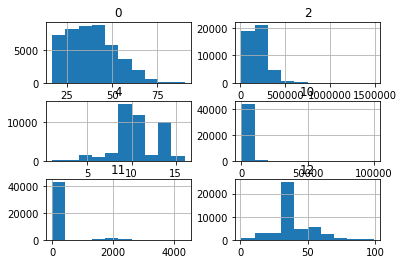

(45222, 14) (45222,) Counter({0: 34014, 1: 11208})
DummyClassifier(constant=None, random_state=None, strategy='most_frequent') : [0.75215565 0.75215565 0.75232198 0.75232198 0.75210084 0.75210084
 0.75210084 0.75210084 0.75210084 0.75210084 0.75215565 0.75215565
 0.75232198 0.75232198 0.75210084 0.75210084 0.75210084 0.75210084
 0.75210084 0.75210084 0.75215565 0.75215565 0.75232198 0.75232198
 0.75210084 0.75210084 0.75210084 0.75210084 0.75210084 0.75210084]
Mean Accuracy: 0.752 (0.000)


In [27]:
# define the location of the dataset
full_path = 'adult-all-raw.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='most_frequent')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [28]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# define steps
	steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
	# one hot encode categorical, normalize numerical
	ct = ColumnTransformer(steps)
	# wrap the model i a pipeline
	pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pipeline)
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

Pipeline(memory=None,
         steps=[('t',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('c',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  Int64Index([1, 3, 5, 6, 7, 8, 9, 13], dtype='int64')),
                                                 ('n',
                                                  MinMaxScaler(copy=True,
                                                               

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Pipeline(memory=None,
         steps=[('t',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('c',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  Int64Index([1, 3, 5, 6, 7, 8, 9, 13], dtype='int64')),
                                                 ('n',
                                                  MinMaxScaler(copy=True,
                                                               

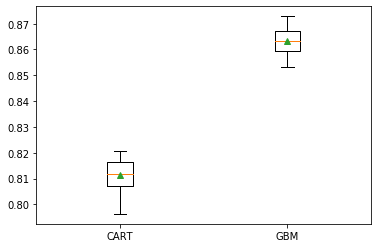

In [30]:
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()